<a href="https://colab.research.google.com/github/itberrios/CV_tracking/blob/main/tutorial_yolo_nas_and_ocsort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **YOLO-NAS + OC-SORT**

This notebook contains a tutorial that shows how to incorporate YOLO-NAS with OC-SORT to perform real time visual tracking on a data stream. In this case, we will use a YouTube video to simulate a data stream of image frames.

## **YOLO-NAS**
[YOLO-NAS](https://github.com/Deci-AI/super-gradients/blob/master/YOLONAS.md) is a powerful object detector with an optimal neural network architecture that has been selected using Neural Architecture Search (NAS), hence the name NAS. 

At the time of release, it outperforms all of the other single shot object detectos in terms of speed and accuracy. It also excels in an area that most single shot detector struggle with, small objects. Two-stage detectors typically perform better than single stage detectors on small objects, at the cost of increased detection time [source](https://arxiv.org/pdf/1907.09408.pdf). YOLO-NAS, howver seems to provide a good tradeoff between detection speed and accuracy on small objects that previous versions of YOLO have not been able to deliver.

## **OC-SORT**
[OC-SORT](https://arxiv.org/abs/2203.14360) is a robust visual obejct tracking algorithm that improves upon the already popular [SORT](https://arxiv.org/abs/1602.00763) algorithm.

SORT tends to loose track on obejcts when they are lost for extended periods of time or when non-linear motion occurs. Algorithms such as Deep SORT have effectoively improved SORT in these scenarios with a Deep Association metric that is computed with a [Siamese Neural Network](https://arxiv.org/pdf/1707.02131.pdf) over the image patches. Eventhough this is effective it comes with the cost of increased detection time due to the deep association and the Siamese network needs to be trained on in-domain data for this approach to be effective. OC-SORT on the otherhand is able to effectively increase tracking performance in a model free fashion with minimal impact to inference speed.

OC-SORT introduces
- Observation Centric Re-Update (ORU)
    - Reduces accumulated Kalman Filter error/uncertainty when a lost track is re-associated
- Observation Centric Momentum (OCM)
    - Uses previous observations to compute a low noise expected motion direction and incorporates it into the track association cost
- Observation Centric Recovery (OCR)
    - Uses the last known observation as a secondary association to help prevent lost tracks

For more details and a break down of each technique that OC-SORT introduces, please see this [article](https://medium.com/@itberrios6/introduction-to-ocsort-c1ea1c6adfa2).

## NOTE
For this tutorial, we will not be able to use the supergradients API directly since it will slow down the inference. We will need to work with the model directly and call it's forward function.

#### Install Libraries

In [3]:
# sketchy fix for "https://stackoverflow.com/questions/73711994/importerror-cannot-import-name-is-directory-from-pil-util-usr-local-lib"
!pip install fastcore -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [315]:
!pip install pytorch-quantization --extra-index-url https://pypi.ngc.nvidia.com

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.4 MB/s eta 0:00:00


In [ ]:
!pip install super-gradients
!pip install filterpy
!pip install pytube
!pip install moviepy
!pip install ffmpeg

# bug fix for imageio-ffmpeg
!pip install imageio==2.4.1

### Get OCSORT code

In [98]:
!mkdir ocsort
%cd ocsort
!wget https://raw.githubusercontent.com/noahcao/OC_SORT/master/trackers/ocsort_tracker/ocsort.py 
!wget https://raw.githubusercontent.com/noahcao/OC_SORT/master/trackers/ocsort_tracker/kalmanfilter.py 
!wget https://raw.githubusercontent.com/noahcao/OC_SORT/master/trackers/ocsort_tracker/association.py 

%cd ..

/content/ocsort
--2023-05-07 23:31:40--  https://raw.githubusercontent.com/noahcao/OC_SORT/master/trackers/ocsort_tracker/ocsort.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18109 (18K) [text/plain]
Saving to: ‘ocsort.py’

ocsort.py           100%[===================>]  17.68K  --.-KB/s    in 0.001s  

2023-05-07 23:31:40 (23.1 MB/s) - ‘ocsort.py’ saved [18109/18109]



In [5]:
import os
import time
import numpy as np
import cv2
import filterpy
import super_gradients as sg
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

[2023-05-07 23:00:46] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-05-07 23:00:51] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-07 23:00:51] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-07 23:00:51] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-07 23:00:51] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


## Download video from YouTube

In [7]:
from pytube import YouTube

# current bug in PYTube prevents this code from working

url = r"https://www.youtube.com/watch?v=JteKbauGolo"
yt = YouTube(url)
print("Video Title: ", yt.title)

# download video
video_path = yt.streams \
  .filter(progressive=True, file_extension='mp4') \
  .order_by('resolution') \
  .desc() \
  .first() \
  .download() 

Video Title:  Chastain BANZAI last lap move!!


## Instantiate YOLO-NAS model

In [633]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

model = models.get("yolo_nas_s", pretrained_weights="coco").cuda()
model.to('cuda'); # ensure model is on GPU

### Quantize model for better speed

This produces an error

In [361]:
# from super_gradients.training.utils.quantization.selective_quantization_utils import SelectiveQuantizer

# q_util = SelectiveQuantizer(
#     default_quant_modules_calibrator_weights="max",
#     default_quant_modules_calibrator_inputs="histogram",
#     default_per_channel_quant_weights=True,
#     default_learn_amax=False,
#     verbose=True,
# )
# q_util.quantize_module(model)

## Perform inference on Simulated Video Stream

#### First we will use MoviePy to get the frame rate and save the audio for later

In [9]:
from moviepy.editor import VideoFileClip

videoclip = VideoFileClip(video_path)
audioclip = videoclip.audio

video_fps = videoclip.fps
video_fps

29.97002997002997

## Instantiate tracker object

In [220]:
from ocsort import ocsort

tracker = ocsort.OCSort(det_thresh=0.25)

Helper function for bounding box colors

In [221]:
import colorsys    

def get_color(number):
    """ Converts an integer number to a color """
    # change these however you want to
    hue = number*30 % 180
    saturation = number*103 % 256
    value = number*50 % 256

    # expects normalized values
    color = colorsys.hsv_to_rgb(hue/179, saturation/255, value/255)

    return [int(c*255) for c in color]

## Now we can simualate the data stream using opencv

Make sure to reset the tracker each time you run the inference

In [372]:
# get frame info for tracker and video saving 
h, w = (720, 1280)
h2, w2 = h//2, w//2
h2, w2 = 640, 640
img_size = (h2, w2) 
img_info = (h2, w2)

In [404]:
model

YoloNAS_S(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=Tr

In [461]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_class_names',
 '_default_nms_conf',
 '_default_nms_iou',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_get_pipeline',
 '_image_processor',
 '_initialize_weights',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_registe

In [463]:
model.heads

NDFLHeads(
  (head1): YoloNASDFLHead(
    (stem): ConvBNReLU(
      (seq): Sequential(
        (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
    )
    (cls_convs): Sequential(
      (0): ConvBNReLU(
        (seq): Sequential(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): ReLU(inplace=True)
        )
      )
    )
    (reg_convs): Sequential(
      (0): ConvBNReLU(
        (seq): Sequential(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): ReLU(inplace=True)
        )
      )
    )
    (cls_pred): Conv2d(64, 8

In [387]:
torch.tensor(frame).permute(2, 0, 1).shape

torch.Size([3, 640, 640])

In [448]:
import torch

img = torch.tensor(frame, dtype=torch.float).permute(2, 0, 1).unsqueeze(0)
img.shape

torch.Size([1, 3, 640, 640])

In [449]:
img = torch.tensor(frame, dtype=torch.float).permute(2, 0, 1).unsqueeze(0)
preds = model.forward(img.to('cuda'))
len(preds)

6

In [450]:
preds[0].shape # classes

torch.Size([1, 8400, 80])

In [471]:
preds[1].shape

torch.Size([1, 8400, 68])

In [472]:
preds[1]

tensor([[[ 7.3904,  7.2405,  2.7847,  ..., -1.2027, -1.4702, -1.0988],
         [ 4.0606,  6.1702,  6.0505,  ..., -0.7240, -1.0094, -0.7167],
         [ 3.3394,  3.6067,  4.6372,  ..., -1.2664, -1.4186, -1.2110],
         ...,
         [-1.3347, -0.1555,  2.2083,  ..., -1.2111, -1.4855, -1.2931],
         [-0.7693,  0.4767,  3.4625,  ..., -1.2114, -1.4547, -1.2644],
         [-0.6285, -0.0805,  1.4880,  ..., -1.0897, -1.2862, -1.1091]]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [451]:
preds[2].shape # bboxes

torch.Size([8400, 4])

In [473]:
preds[0]

tensor([[[-7.1151, -7.3826, -7.5394,  ..., -7.6448, -7.0123, -6.7202],
         [-8.2822, -7.9217, -8.1151,  ..., -8.2997, -7.6201, -7.4843],
         [-8.1070, -8.1143, -8.0598,  ..., -8.2473, -7.6558, -7.1799],
         ...,
         [-1.2624, -4.2480, -4.1913,  ..., -3.5421, -4.6780, -4.6810],
         [-0.9450, -4.0330, -4.2074,  ..., -3.5729, -4.5259, -4.4764],
         [-1.0409, -3.5628, -4.0938,  ..., -3.7110, -4.2926, -4.3301]]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [470]:
preds[][1000:1010]

tensor([[304.,  80., 344., 120.],
        [312.,  80., 352., 120.],
        [320.,  80., 360., 120.],
        [328.,  80., 368., 120.],
        [336.,  80., 376., 120.],
        [344.,  80., 384., 120.],
        [352.,  80., 392., 120.],
        [360.,  80., 400., 120.],
        [368.,  80., 408., 120.],
        [376.,  80., 416., 120.]], device='cuda:0')

In [458]:
preds[3].shape

torch.Size([8400, 2])

In [408]:
preds[4]

[6400, 1600, 400]

In [459]:
preds[5].shape

torch.Size([8400, 1])

In [469]:
preds[5]

tensor([[ 8.],
        [ 8.],
        [ 8.],
        ...,
        [32.],
        [32.],
        [32.]], device='cuda:0')

In [446]:
predictions = model.predict(frame)
img_preds = list(predictions._images_prediction_lst)[0]

In [447]:
dets = np.hstack((img_preds.prediction.bboxes_xyxy, 
                      np.c_[img_preds.prediction.confidence]))
dets

array([[3.3173352e+02, 3.4883377e+02, 3.7839752e+02, 4.0105792e+02,
        3.8426915e-01],
       [3.5739014e+02, 3.4835440e+02, 4.0479556e+02, 4.0168695e+02,
        3.3936629e-01],
       [1.7131293e+02, 3.5235922e+02, 2.0814070e+02, 4.0982120e+02,
        3.0975449e-01],
       [1.4576219e+02, 3.5401987e+02, 1.8556717e+02, 4.1245587e+02,
        3.0594549e-01],
       [1.4576068e+02, 3.5254861e+02, 2.0784404e+02, 4.1268716e+02,
        2.9847553e-01],
       [5.0976852e+02, 5.5291034e+02, 5.8526166e+02, 6.3956860e+02,
        2.9431695e-01],
       [3.1160901e+02, 3.2953787e+02, 3.1868451e+02, 3.4239359e+02,
        2.6015297e-01],
       [5.1561954e+01, 4.6656332e+02, 6.4834518e+01, 4.9418881e+02,
        2.5123236e-01]], dtype=float32)

In [493]:
predictions = model.predict(images=[frame], iou=None, conf=0.25)._images_prediction_lst
dir(predictions._images_prediction_lst)

['__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__next__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'close',
 'gi_code',
 'gi_frame',
 'gi_running',
 'gi_yieldfrom',
 'send',
 'throw']

In [564]:
t = time.perf_counter()
p = model.predict(images=[frame], iou=None, conf=0.25)
tmp = list(p._images_prediction_lst)[0]
time.perf_counter() - t

0.058285760998842306

In [565]:
t = time.perf_counter()
tmp = list(model.predict(images=[frame], iou=None, conf=0.25)._images_prediction_lst)[0]
time.perf_counter() - t

0.07111401499969361

In [566]:
t = time.perf_counter()
tmp = next(model.predict(images=[frame], iou=None, conf=0.25)._images_prediction_lst)
time.perf_counter() - t

0.06556094400002621

In [567]:
t = time.perf_counter()
tmp = next(iter(model.predict(images=[frame], iou=None, conf=0.25)._images_prediction_lst))
time.perf_counter() - t

0.05901284299943654

In [549]:
dir(predictions)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_images_prediction_lst',
 'save',
 'show']

In [552]:
predictions.__getattribute__('bboxes_xyxy')

AttributeError: ignored

In [556]:
import inspect



os.path.abspath(inspect.getfile(model.predict))

'/usr/local/lib/python3.10/dist-packages/super_gradients/training/models/detection_models/customizable_detector.py'

In [569]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_class_names',
 '_default_nms_conf',
 '_default_nms_iou',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_get_pipeline',
 '_image_processor',
 '_initialize_weights',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_registe

In [608]:
from super_gradients.training.models.detection_models.customizable_detector import CustomizableDetector
from super_gradients.training.pipelines.pipelines import DetectionPipeline

pipeline = DetectionPipeline(
            model=model,
            image_processor=model._image_processor,
            post_prediction_callback=model.get_post_prediction_callback(iou=0.25, conf=0.25),
            class_names=model._class_names,
        )

In [677]:
tmp = pipeline(frame)

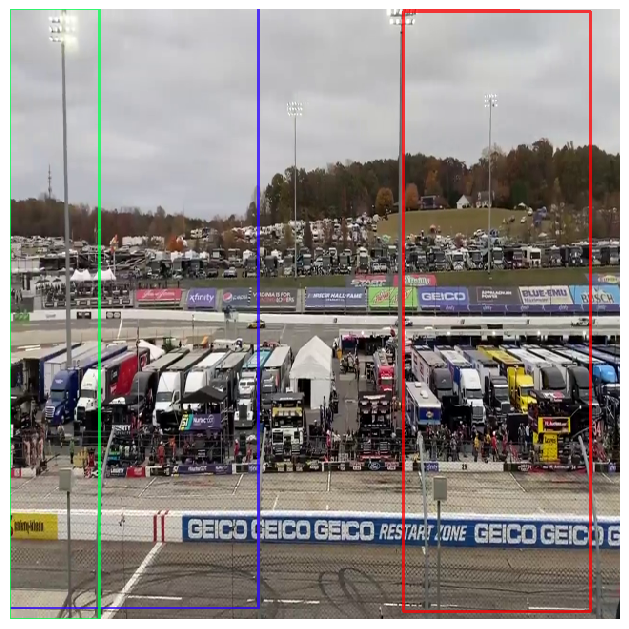

In [678]:
tmp.show()

In [619]:
frame.shape

(640, 640, 3)

In [620]:
frame.transpose(2, 0, 1).shape

(3, 640, 640)

In [621]:
tmp = pipeline._generate_prediction_result_single_batch(frame.transpose(2, 0, 1))
tmp

<generator object Pipeline._generate_prediction_result_single_batch at 0x7f87d18e7370>

In [622]:
list(tmp)[0]

ValueError: ignored

# Sketchy prediction approach to reduce overhead

In [611]:
def eval_mode(model):
    """Set a model in evaluation mode and deactivate gradient computation, undo at the end.
    :param model: The model to set in evaluation mode.
    """
    _starting_mode = model.training
    model.eval()
    with torch.no_grad():
        yield
    model.train(mode=_starting_mode)

In [642]:
images = [frame]

# Preprocess
preprocessed_images, processing_metadatas = [], []
for image in images:
    preprocessed_image, processing_metadata = pipeline.image_processor.preprocess_image(image=image.copy())
    preprocessed_images.append(preprocessed_image)
    processing_metadatas.append(processing_metadata)

# Predict
# with eval_mode(pipeline.model):
with torch.no_grad():
    torch_inputs = torch.Tensor(np.array(preprocessed_images)).to(pipeline.device)
    model_output = model(torch_inputs)
    predictions = pipeline._decode_model_output(model_output, model_input=torch_inputs)

# Postprocess
postprocessed_predictions = []
for image, prediction, processing_metadata in zip(images, predictions, processing_metadatas):
    prediction = pipeline.image_processor.postprocess_predictions(predictions=prediction, metadata=processing_metadata)
    postprocessed_predictions.append(prediction)


ValueError: ignored

In [643]:
len(model_output)

6

In [662]:
# TEMP
image = frame.copy()

# Preprocess
preprocessed_image, processing_metadata = pipeline.image_processor.preprocess_image(image=image.copy())

# Predict
with torch.no_grad():
    torch_input = torch.Tensor(preprocessed_image).unsqueeze(0).to('cuda')
    model_output = model(torch_input)
    output = (model_output[2].unsqueeze(0), model_output[0])
    prediction = pipeline._decode_model_output([output], model_input=torch_input)

# Postprocess
prediction = pipeline.image_processor.postprocess_predictions(predictions=prediction, metadata=processing_metadata)


AttributeError: ignored

In [651]:
for pred_bboxes, pred_scores in zip(*output):
  print(a)

In [636]:
torch_input.shape

torch.Size([1, 3, 640, 640])

In [645]:
model_output[0].shape, model_output[2].shape

(torch.Size([1, 8400, 80]), torch.Size([8400, 4]))

In [661]:
for a,b in (output):
  print(a)

ValueError: ignored

In [675]:
res = post_pred(output, device='cuda')

In [676]:
res

[]

In [669]:
output

(tensor([[[-16., -16.,  24.,  24.],
          [ -8., -16.,  32.,  24.],
          [  0., -16.,  40.,  24.],
          ...,
          [480., 544., 640., 704.],
          [512., 544., 672., 704.],
          [544., 544., 704., 704.]]], device='cuda:0'),
 tensor([[[-6.9464, -7.4081, -7.4146,  ..., -7.0913, -7.2517, -6.8631],
          [-7.2418, -7.1729, -7.1358,  ..., -7.0859, -7.2123, -7.1449],
          [-6.1652, -6.6199, -6.2445,  ..., -6.5481, -6.7157, -6.5927],
          ...,
          [-5.5096, -5.2572, -5.2204,  ..., -5.2751, -5.3806, -5.3874],
          [-5.5577, -5.5817, -5.5257,  ..., -5.5319, -5.6390, -5.6354],
          [-5.1860, -5.3787, -5.4438,  ..., -5.4115, -5.5192, -5.5068]]],
        device='cuda:0'))

In [655]:
import torchvision

In [674]:
def post_pred(outputs, device):
      """

      :param x: Tuple of (bboxes, scores) of shape [B, Anchors, 4], [B, Anchors, C]
      :param device:
      :return:
      """
      # replace class attrs
      multi_label_per_box = True
      score_threshold = 0.25
      nms_top_k = 40

      nms_result = []
      # First is model predictions, second element of tuple is logits for loss computation
      # predictions = outputs[0]

      for pred_bboxes, pred_scores in zip(*predictions):
          # pred_bboxes [Anchors, 4],
          # pred_scores [Anchors, C]

          # Filter all predictions by self.score_threshold
          if multi_label_per_box:
              i, j = (pred_scores > score_threshold).nonzero(as_tuple=False).T
              pred_bboxes = pred_bboxes[i]
              pred_cls_conf = pred_scores[i, j]
              pred_cls_label = j[:]

          else:
              pred_cls_conf, pred_cls_label = torch.max(pred_scores, dim=1)
              conf_mask = pred_cls_conf >= score_threshold

              pred_cls_conf = pred_cls_conf[conf_mask]
              pred_cls_label = pred_cls_label[conf_mask]
              pred_bboxes = pred_bboxes[conf_mask, :]

          # Filter all predictions by self.nms_top_k
          if pred_cls_conf.size(0) > nms_top_k:
              topk_candidates = torch.topk(pred_cls_conf, k=nms_top_k, largest=True)
              pred_cls_conf = pred_cls_conf[topk_candidates.indices]
              pred_cls_label = pred_cls_label[topk_candidates.indices]
              pred_bboxes = pred_bboxes[topk_candidates.indices, :]

          # NMS
          idx_to_keep = torchvision.ops.boxes.batched_nms(boxes=pred_bboxes, scores=pred_cls_conf, idxs=pred_cls_label, iou_threshold=self.nms_threshold)

          pred_cls_conf = pred_cls_conf[idx_to_keep].unsqueeze(-1)
          pred_cls_label = pred_cls_label[idx_to_keep].unsqueeze(-1)
          pred_bboxes = pred_bboxes[idx_to_keep, :]

          #  nx6 (x1, y1, x2, y2, confidence, class) in pixel units
          final_boxes = torch.cat([pred_bboxes, pred_cls_conf, pred_cls_label], dim=1)  # [N,6]

          nms_result.append(final_boxes)

      # return _filter_max_predictions(nms_result)
      return nms_result

def _filter_max_predictions(res):
      # replace class attrs
      max_predictions = 500
      res[:] = [im[: max_predictions] if (im is not None and im.shape[0] > max_predictions) else im for im in res]

      return res

In [666]:
preds = model(torch_inputs)
len(preds)

6

In [547]:
# ensure tracker is reset
tracker = ocsort.OCSort(det_thresh=0.25)

cap = cv2.VideoCapture(video_path)

if (cap.isOpened() == False):
    print("Error opening video file")

frames = []
i = 0
fps = 0
tic = time.perf_counter()
elapsed = 0
while(cap.isOpened()):

  # read each video frame
  ret, frame = cap.read()

  if ret == True:

    # read image and resize
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(
        cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 
        (w2, h2), interpolation=cv2.INTER_LINEAR)
    
    # perform direct inference
    # img = torch.tensor(frame, dtype=torch.float).permute(2, 0, 1).unsqueeze(0)
    # preds = model.forward(img.to('cuda'))

    # # perform inference
    predictions = model.predict(images=[frame], iou=None, conf=0.25)

    # get detections
    # img_preds = list(predictions._images_prediction_lst)[0]

    # dets = np.hstack((img_preds.prediction.bboxes_xyxy, 
    #                   np.c_[img_preds.prediction.confidence]))

    # update tracker
    # tracks = tracker.update(dets, img_info, img_size)

    # # draw tracks on frame
    # for track in tracker.trackers:
      
    #   track_id = track.id
    #   hits = track.hits
    #   color = get_color(track_id*15)
    #   x1,y1,x2,y2 = np.round(track.get_state()).astype(int).squeeze()

    #   cv2.rectangle(frame, (x1,y1),(x2,y2), color, 2)
    #   cv2.putText(frame, 
    #               f"{track_id}-{hits}", 
    #               (x1+10,y1+10), 
    #               cv2.FONT_HERSHEY_SIMPLEX, 
    #               1,
    #               color, 
    #               2,
    #               cv2.LINE_AA)
      
    # update FPS
    elapsed = (time.perf_counter() - tic)
    fps = np.round((i+1)/elapsed, 4)
    # print(i, np.round(elapsed,4), np.round(fps,4), 
    #       np.round(time.perf_counter(),4), np.round(tic,4))
    # cv2.putText(frame, 
    #             f"FPS: {fps}", 
    #             (10,h2 - 10), 
    #             cv2.FONT_HERSHEY_SIMPLEX, 
    #             2,
    #             (255,255,255), 
    #             4,
    #             cv2.LINE_AA)

    # append to list
    frames.append(frame)

    # TEMP for debug
    if i == 30:
      break
    else:
      i += 1

  # Break the loop
  else:
    break

# When everything done, release
# the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [548]:
fps

106.0114

In [347]:
tic, time.perf_counter() 

(6442.148347271, 6443.89801491)

In [378]:
i/elapsed

2.114810211700104

In [349]:
# dir(track)

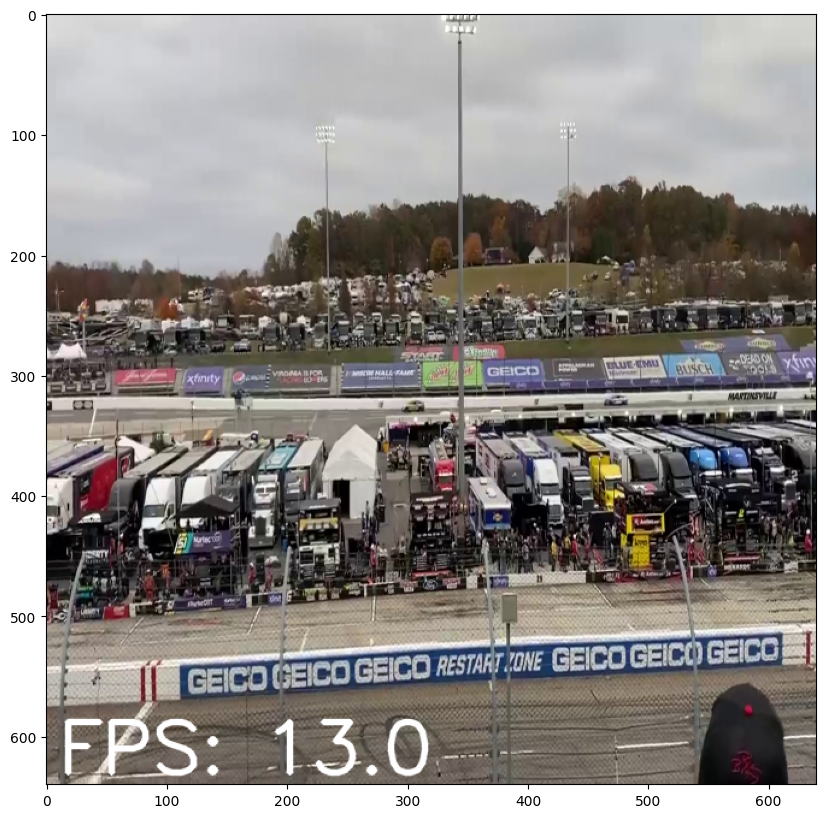

In [376]:
plt.imshow(frames[-1])

## Now let's put this in a video

In [248]:
# save to mp4
out = cv2.VideoWriter('chastain_wall_ride.mp4',
                      cv2.VideoWriter_fourcc(*'MP4V'), 
                      video_fps,
                      (w, h))
 
for frame in frames:
    out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
out.release()

### Now add back the audio

In [249]:
from moviepy.editor import CompositeAudioClip
detection_video = VideoFileClip('chastain_wall_ride.mp4')

# add sound and save
detection_video.audio = CompositeAudioClip([audioclip])
detection_video.write_videofile('chastain_wall_ride_with_audio.mp4')

Moviepy - Building video chastain_wall_ride_with_audio.mp4.
MoviePy - Writing audio in chastain_wall_ride_with_audioTEMP_MPY_wvf_snd.mp3


t:   0%|          | 0/1049 [00:00<?, ?it/s, now=None]

MoviePy - Done.
Moviepy - Writing video chastain_wall_ride_with_audio.mp4



t: 100%|██████████| 1049/1049 [01:50<00:00, 12.31it/s, now=None][2023-05-08 00:16:23] WARNING - warnings.py - /usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file chastain_wall_ride.mp4, 2764800 bytes wanted but 0 bytes read,at frame 1048/1049, at time 34.97/35.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

